In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import copy
from collections import Counter

In [58]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size):
    """
    Generate specific patterns for 5 modes.
    """
    pats = []
    temp_pats = create_specific_patterns4(mode1, mode2, mode3, mode4, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode5] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns8(mode1, mode2, mode3, mode4, mode5, mode6, mode7, mode8, size):
    """
    Generate specific patterns for 8 modes.
    """
    pats = []
    temp_pats = create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode6] = bin_to_pattern(str(k))[0]
            for l in range(2):
                p_prime2 = copy.deepcopy(p_prime)
                p_prime2[mode7] = bin_to_pattern(str(l))[0]
                for m in range(2):
                    p_prime3 = copy.deepcopy(p_prime2)
                    p_prime3[mode8] = bin_to_pattern(str(m))[0]
                    pats.append(p_prime3)
    return pats
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

In [45]:
def stringify(seq):
    string = ''
    for n in seq:
        string+=str(n)
    return string

In [217]:
n = 14
sequence_list = np.array([np.array(list(bin(i)[3:]),dtype=np.int32) for i in range(2**n, 2**(n+1))])
len(sequence_list)

16384

In [47]:
def generate_rules_and_rewards(num_rules=5, rule_length=4, reward_range=(1, 20), sequence_length=12):
    """
    Generate rules, rewards, and starting positions for the rules.
    """
    rules = set()
    rewards = []
    starting_positions = []

    while len(rules) < num_rules:
        rule = tuple(np.random.randint(0, 2, size=rule_length))  # Generate a random rule
        if rule not in rules:
            rules.add(rule)
            reward = np.random.randint(reward_range[0], reward_range[1])  # Generate a random reward
            rewards.append(reward)
            # Generate one or more starting positions for the rule
            positions = np.random.choice(range(sequence_length - rule_length + 1), size=np.random.randint(1, 12-rule_length), replace=False)
            starting_positions.append(list(positions))

    return list(rules), rewards, starting_positions


def estimate_cost(sequence, rules, rewards, starting_positions=None):
    """
    Estimate the cost of a sequence based on the rules, rewards, and starting positions.
    """
    if rules== [] or rewards == []:
        return 0

    if starting_positions is None:
        starting_positions = [list(range(len(sequence) - len(rules[0]) + 1))] * len(rules)

    reward = 0
    rule_length = len(rules[0])

    for rule, rule_reward, positions in zip(rules, rewards, starting_positions):
        for k in positions:  # Only check the specified starting positions
            if k + rule_length <= len(sequence) and np.all(sequence[k:k + rule_length] == rule):
                reward += rule_reward
                # break  # Stop checking further positions for this rule if it matches

    return np.abs(reward)

In [48]:
def random_repartition(nb_rules,into=5):
    """
    Generate a random repartition of 5 values whose sum equals nb_rules.
    """
    values = np.random.multinomial(nb_rules, [1/into]*into)
    return values


In [326]:
rules1, rewards1,pos = generate_rules_and_rewards(num_rules=2,rule_length=3)
print(rules1)

sequence_cost = []
for sequence in sequence_list:
    rew = 0
    rew += estimate_cost(sequence,rules1, rewards1)
    # rew += estimate_cost(sequence,rules2, rewards2)
    # rew += estimate_cost(sequence,rules3, rewards3)
    sequence_cost.append(rew)
sequence_cost = np.array(sequence_cost)
sequence_cost = sequence_cost /np.linalg.norm(sequence_cost)

# plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=1.5)
# plt.show()

[(0, 0, 0), (0, 1, 1)]


Rules 2: (array([1, 0, 0]), array([1, 1, 1]))
Rules 3: (array([0, 1, 0]), array([0, 0, 1]))
Rules 4: (array([0, 0, 1]), array([0, 1, 0]))


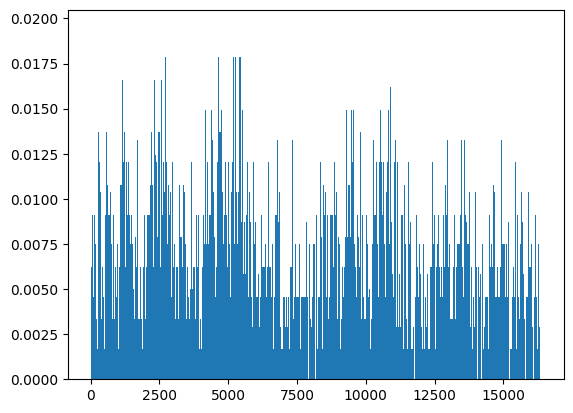

In [327]:
# Given a set of rules (rules1), create 3 new sets where each set has one rule differing by one bit

def generate_one_bit_variants(rules1):
    """
    For each rule in rules1, generate 3 new sets of rules, each with one rule differing by one bit.
    Returns a list of 3 new sets.
    """
    rules1 = np.array(rules1)
    n_rules, rule_length = rules1.shape
    new_rule_sets = []

    for i in range(3):
        # Copy the original rules
        new_rules = rules1.copy()
        # Pick a rule to modify (cycle through the first 3 rules)
        rule_idx = i % n_rules
        # Pick a bit to flip (cycle through the first 3 bits)
        bit_idx = i % rule_length
        # Flip the bit
        new_rules[rule_idx, bit_idx] = 1 - new_rules[rule_idx, bit_idx]
        new_rule_sets.append(tuple(new_rules))
    return new_rule_sets

def generate_all_one_bit_variants(rules1):
    """
    For a set of rules (rules1), generate 3 new sets of rules.
    In each set, every rule differs from the original by flipping one bit (the bit index is different for each set).
    Returns a list of 3 new sets.
    """
    rules1 = np.array(rules1)
    n_rules, rule_length = rules1.shape
    new_rule_sets = []

    for bit_idx in range(3):
        new_rules = rules1.copy()
        for rule_idx in range(n_rules):
            flip_idx = bit_idx % rule_length
            new_rules[rule_idx, flip_idx] = 1 - new_rules[rule_idx, flip_idx]
        new_rule_sets.append(tuple(new_rules))
    return new_rule_sets

# Example usage:
rules2,rules3,rules4 = generate_all_one_bit_variants(rules1)

print("Rules 2:", rules2)
sequence_cost2 = []
for sequence in sequence_list:
    rew = 0
    rew += estimate_cost(sequence, rules2, rewards1)  # Use the same rewards for both rules
    sequence_cost2.append(rew)
sequence_cost2 = np.array(sequence_cost2)
sequence_cost2 = sequence_cost2 / np.linalg.norm(sequence_cost2)

# plt.bar([i for i in np.arange(len(sequence_list))], sequence_cost2, width=1.5)
# plt.show()

print("Rules 3:", rules3)
sequence_cost3 = []
for sequence in sequence_list:
    rew = 0
    rew += estimate_cost(sequence, rules3, rewards1)  # Use the same rewards for both rules
    sequence_cost3.append(rew)
sequence_cost3 = np.array(sequence_cost3)
sequence_cost3 = sequence_cost3 / np.linalg.norm(sequence_cost3)

# plt.bar([i for i in np.arange(len(sequence_list))], sequence_cost3, width=1.5)
# plt.show()

print("Rules 4:", rules4)
sequence_cost4 = []
for sequence in sequence_list:
    rew = 0
    rew += estimate_cost(sequence, rules4, rewards1)  # Use the same rewards for both rules
    sequence_cost4.append(rew)
sequence_cost4 = np.array(sequence_cost4)
sequence_cost4 = sequence_cost4 / np.linalg.norm(sequence_cost4)

plt.bar([i for i in np.arange(len(sequence_list))], sequence_cost4, width=1.5)
plt.show()

In [328]:
#pairs
# all_pat = []
# for i in range(n-1):
#     all_pat += create_specific_patterns(i,i+1,n)
# Phi = np.array([dev_pattern(p) for p in all_pat])

#quadruplets
# all_pat = []
# for i in range(n-3):
#     all_pat += create_specific_patterns4(i,i+1,i+2,i+3,n)
# Phi = np.array([dev_pattern(p) for p in all_pat])

#quintuplets
# all_pat = []
# for i in range(n-4):
#     all_pat += create_specific_patterns5(i,i+1,i+2,i+3,i+4,n)
# Phi = np.array([dev_pattern(p) for p in all_pat])

#random
Phi = np.random.randn(300,2**n)

y1 = Phi @ sequence_cost
y1 = y1 / np.linalg.norm(y1)

y2 = Phi @ sequence_cost2
y2 = y2 / np.linalg.norm(y2)

y3 = Phi @ sequence_cost3
y3 = y3 / np.linalg.norm(y3)
y4 = Phi @ sequence_cost4
y4 = y4 / np.linalg.norm(y4)

d1 = np.linalg.norm(y1-y2)
d2 = np.linalg.norm(y1-y3)
d3 = np.linalg.norm(y1-y4)
print(d1, d2, d3)

0.7196755727160339 0.6444689673448031 0.726124388642435


In [329]:
threshold_level = 80
thresh =  np.percentile(sequence_cost, threshold_level)
sequence_cost_thresh = sequence_cost.copy()
sequence_cost_thresh[sequence_cost_thresh < thresh] = 0

y1_thresh = Phi @ sequence_cost_thresh
y1_thresh = y1_thresh / np.linalg.norm(y1_thresh)

thresh =  np.percentile(sequence_cost2, threshold_level)
sequence_cost2_thresh = sequence_cost2.copy()
sequence_cost2_thresh[sequence_cost2_thresh < thresh] = 0
y2_thresh = Phi @ sequence_cost2_thresh
y2_thresh = y2_thresh / np.linalg.norm(y2_thresh)

thresh =  np.percentile(sequence_cost3, threshold_level)
sequence_cost3_thresh = sequence_cost3.copy()
sequence_cost3_thresh[sequence_cost3_thresh < thresh] = 0
y3_thresh = Phi @ sequence_cost3_thresh
y3_thresh = y3_thresh / np.linalg.norm(y3_thresh)

thresh =  np.percentile(sequence_cost4, threshold_level)
sequence_cost4_thresh = sequence_cost4.copy()
sequence_cost4_thresh[sequence_cost4_thresh < thresh] = 0
y4_thresh = Phi @ sequence_cost4_thresh
y4_thresh = y4_thresh / np.linalg.norm(y4_thresh)

d1_thresh = np.linalg.norm(y1_thresh - y2_thresh)
d2_thresh = np.linalg.norm(y1_thresh - y3_thresh)
d3_thresh = np.linalg.norm(y1_thresh - y4_thresh)
print(d1_thresh, d2_thresh, d3_thresh)

1.340968094428509 1.3739914235180561 1.3960933759118437


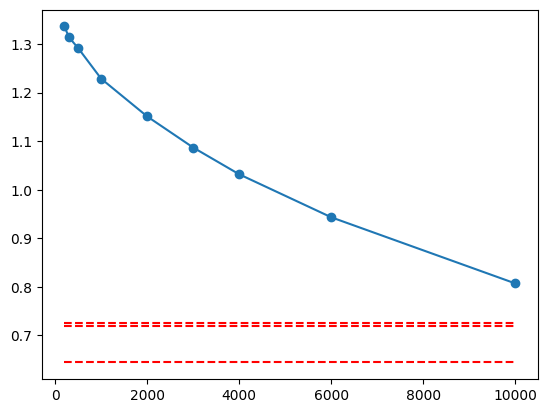

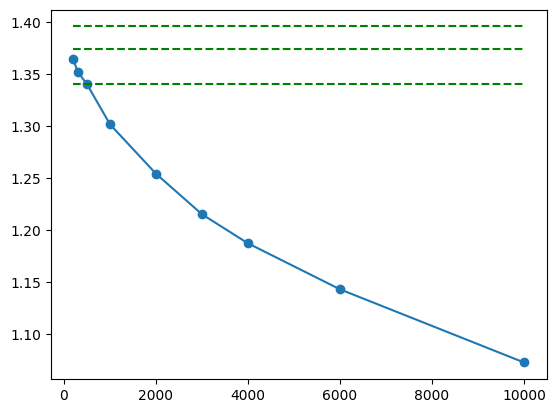

In [330]:
avgdistances = []
avgdistances_thresh = []
sp_size_range = [200,300,500, 1000, 2000, 3000, 4000,6000,10000] 
for sample_size in sp_size_range:

    moments = []
    moments_thresh = []
    for _ in range(300):
        sample_index = np.random.randint(0,len(sequence_list),sample_size)
        sequence_cost_spectrum = np.zeros_like(sequence_cost)
        sequence_cost_spectrum[sample_index] = sequence_cost[sample_index]

        m = Phi @ sequence_cost_spectrum
        m = m / np.linalg.norm(m)
        moments.append(m)

        thresh =  np.percentile(sequence_cost, threshold_level)
        sequence_cost_spectrum[sequence_cost_spectrum<=thresh]=0

        m = Phi @ sequence_cost_spectrum
        m = m / np.linalg.norm(m)
        moments_thresh.append(m)

    distances = []
    for i in range(1,len(moments)):
        distances.append(np.linalg.norm(moments[i] - y1))
    avgdistances.append(np.average(distances))

    distances = []
    for i in range(1,len(moments)):
        distances.append(np.linalg.norm(moments_thresh[i] - y1))
    avgdistances_thresh.append(np.average(distances))

plt.plot(sp_size_range, avgdistances, marker='o')
plt.hlines([d1, d2, d3], xmin=sp_size_range[0], xmax=sp_size_range[-1], colors='r', linestyles='--', label='Distances without threshold')
plt.show()
plt.plot(sp_size_range, avgdistances_thresh, marker='o')
plt.hlines([d1_thresh, d2_thresh, d3_thresh], xmin=sp_size_range[0], xmax=sp_size_range[-1], colors='g', linestyles='--', label='Distances with threshold')
plt.show()